In [2]:
using Pkg, Revise, Plots, ArndtLabTheme
pyplot()
theme(:arndtlab)

includet("../modules/module_functions_net.jl")

In [2]:
using BSON, MetaGraphs, LightGraphs

#sd_net = BSON.load("sd_network_graph.bson")["sd_network"]
#ccs = connected_components(sd_net);
#real_lens = map(length, ccs);

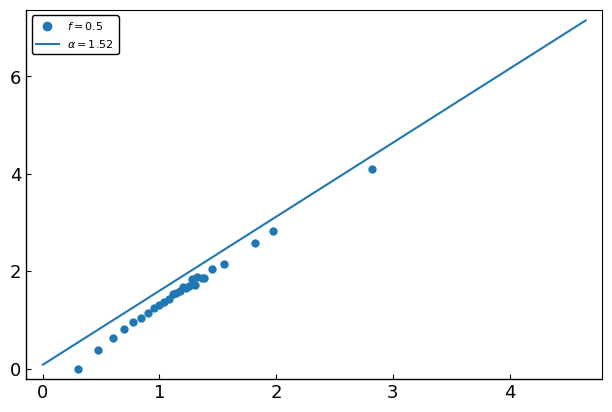

In [3]:
using StatsBase, LaTeXStrings

deltas = [0.00032]
fracs = [0.5]
cols = [1, 2, 3]
alphas = [1.52]
consts = [1.2]
max_elem = 6500
in_mod = "mod2"
out_mod = "com_nodes_edges"

p = plot()
for i in 1:1
    nods_m, edgs_m = MainNetworkGrowth.Network_grow(deltas[i], fracs[i], max_elem, in_mod, out_mod, 
        lim_comp="nodes", start_cnt=2, rem_prob=0.00001);
    
    p = plot!(log10.(nods_m), log10.(edgs_m), markershape=:circle, label=L"$f=$"*"$(fracs[i])",
            line=false, markersize=6, grid=false, color=cols[i], xtickfont=Plots.font(13), ytickfont=Plots.font(13))
end

for i in 1:1
    xs = range(1,stop=45000,length=10)
    ys = consts[i]*xs.^(alphas[i])
    p = plot!(log10.(xs), log10.(ys), color=cols[i], label=L"$\alpha=$"*"$(alphas[i])") 
end

gui(p);

In [4]:
using DistributedArrays, Distributed

pros = addprocs(4)

4-element Array{Int64,1}:
 2
 3
 4
 5

In [33]:
@everywhere include("../modules/module_functions_net.jl")

delta = 0.03
frac = 0.5
max_elem = 1500
in_mod = "mod1"
out_mod = "cc_distr"
rem_pr = 0.001

function run_parallel_growth(delta, frac, max_elem, in_mod, out_mod, steps)
    @async begin 
        global out_sim = pmap(x -> MainNetworkGrowth.Network_grow(delta, frac, max_elem, in_mod, out_mod, 
            lim_comp="nodes", start_cnt=2, nd_lim1=1, nd_lim2=1400, rem_prob=rem_pr), steps)    # nd_lims remove or add!!!
        display("over")
    end
end

run_parallel_growth(delta, frac, max_elem, in_mod, out_mod, 1:1500)

      From worker 2:	WARNING: replacing module MainNetworkGrowth.
      From worker 4:	WARNING: replacing module MainNetworkGrowth.
      From worker 3:	WARNING: replacing module MainNetworkGrowth.
      From worker 5:	WARNING: replacing module MainNetworkGrowth.


Task (runnable) @0x00007fd391c12e60

"over"

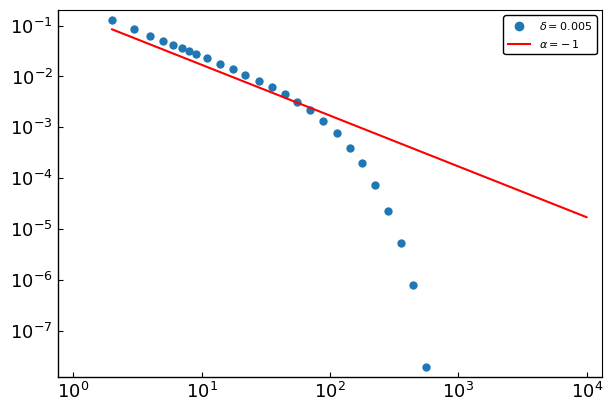

In [15]:
#all_sims = define all_sims

p = plot()

alphas = [1.005, 1.01, 1.05]
colors = [1, 2, 3]

for (i, k) in enumerate([:ucm_005, :ucm_01, :ucm_05])
    p = plot_4_supplementary(p, all_sims[k], alphas[i], colors[i], L"$\delta=$"; lev=3)
end

x = range(2, 10000, length=10); y = 0.17*x.^(-1)
p = plot!(x, y, grid=false, color=:red, label=L"$\alpha=\!-1$")

gui(p)
#savefig("./pics/cc_sup_mod1_deltavalues.pdf")

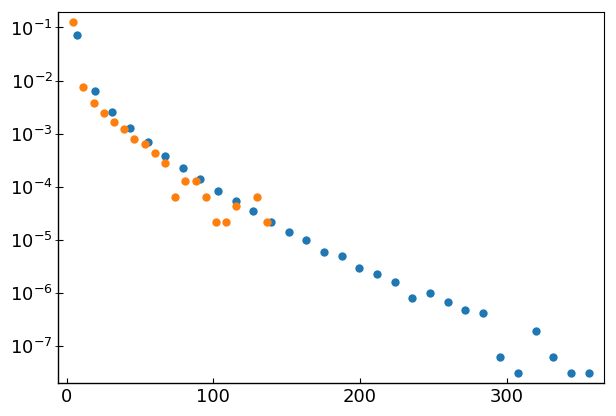

In [8]:
using Histograms

counts = reduce(vcat, out_sim)
h = Histograms.Histogram(counts, N=30, scale=:identity);
nd_p = plot(h, xscale=:identity, yscale=:log10, markershape=:circle, legend=false, grid=false,
    line=false, markersize=6, xtickfont=Plots.font(13), ytickfont=Plots.font(13))

n_deg = map(x -> length(neighbors(sd_net, x)), collect(vertices(sd_net)))
h = Histograms.Histogram(n_deg, N=20, scale=:identity);
nd_p = plot!(h, xscale=:identity, yscale=:log10, markershape=:circle, line=false, markersize=6)

gui(nd_p)
#savefig("./pics/node_degree_real_mod2.pdf")

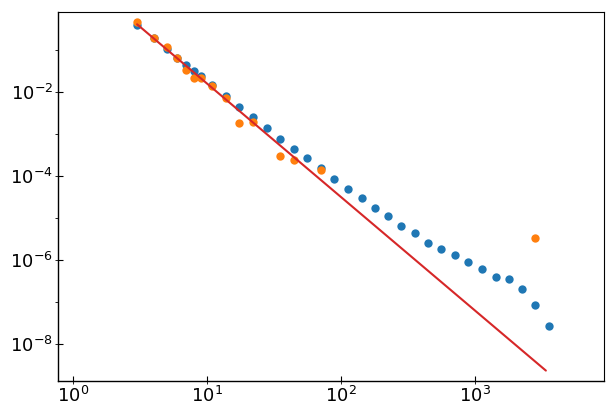

In [24]:
using Histograms

out_filt = filter(x -> 0 < sort(x)[end], out_sim)
counts = reduce(vcat, out_filt)
counts = convert(Array{UInt,1}, counts)
h = Histograms.Histogram(counts[counts .> 2], scale=:log)
p = plot(h, xscale=:log10, yscale=:log10, markershape=:circle, line=false, legend=false, grid=false,
            markersize=6, xtickfont=Plots.font(13), ytickfont=Plots.font(13))

h = Histograms.Histogram(convert(Array{UInt,1}, cc_len[cc_len .> 2]), scale=:log)
p = plot!(h, xscale=:log10, yscale=:log10, markershape=:circle, line=false, markersize=6)

x = range(3, 3400, length=10); y = 8.0*x.^(-2.7);
p = plot!(x, y, grid=false, color=4)
gui(p)

#savefig("./pics/connected_real_mod2.pdf")

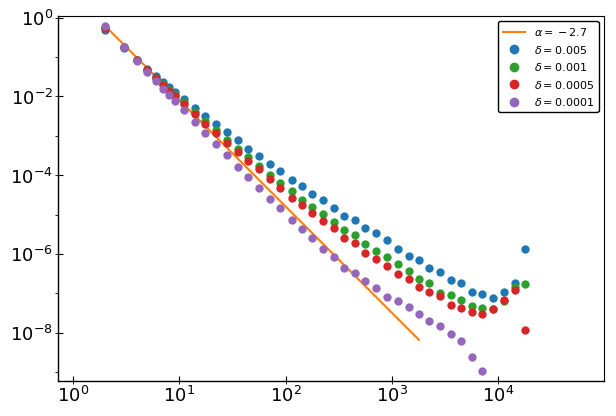

In [27]:
using StatsBase, Histograms, LaTeXStrings, BSON

sims = [sims_dict["sim_1"], sims_dict["sim_2"], sims_dict["sim_3"], sims_dict["sim_4"]]
colors = [1, 3, 4, 5]
legends = [L"$\delta = 0.005$", L"$\delta = 0.001$", L"$\delta = 0.0005$", 
    L"$\delta = 0.0001$", L"$\alpha = -2.7$"]

x = range(2, 1800, length=10); y = 4.0*x.^(-2.7);
p = plot(x, y, grid=false, color=2, label=legends[5])

for i in 1:4
    counts = reduce(vcat, sims[i])
    counts = convert(Array{UInt,1}, counts)
    h = Histograms.Histogram(counts, scale=:log)
    p = plot!(h, xscale=:log10, yscale=:log10, markershape=:circle, line=false, label=legends[i],
            markersize=6, xtickfont=Plots.font(13), ytickfont=Plots.font(13), color=colors[i])
end

gui(p)

#savefig("./pics/cc_mod2_long.pdf")

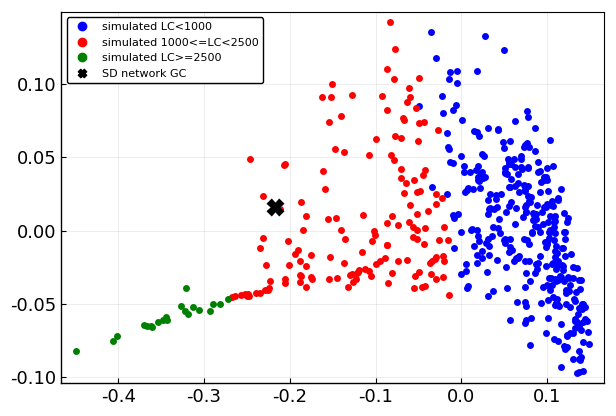

In [10]:
using MultivariateStats

mds_coor = classical_mds(Dist, 2)

my_cgrad = cgrad([:red, :blue])
inds = map(x -> x[end] |> x -> x > 1000 ? 2 : 1, sims)
inds = map(x -> x[end] |> x -> if x < 1000 1; elseif 1000<=x<2500 2; else 3 end, sims)
push!(inds, 4)
            

plot(mds_coor[1, findall(x->x==1, inds)], mds_coor[2, findall(x->x==1, inds)], markercolor="blue", markershape=:circle, markersize=5, 
    line=false, legend=:topleft, xtickfont=Plots.font(13), 
                ytickfont=Plots.font(13), label="simulated LC<1000")
plot!(mds_coor[1, findall(x->x==2, inds)], mds_coor[2, findall(x->x==2, inds)], markercolor="red", markershape=:circle, markersize=5, 
    line=false, label="simulated 1000<=LC<2500")
plot!(mds_coor[1, findall(x->x==3, inds)], mds_coor[2, findall(x->x==3, inds)], markercolor="green", markershape=:circle, markersize=5, 
    line=false, label="simulated LC>=2500")
plot!(mds_coor[1, findall(x->x==4, inds)], mds_coor[2, findall(x->x==4, inds)], markercolor="black", markershape=:xcross, markersize=13, 
    line=false, label="SD network GC")
#savefig("./pics/MDS_simul_SDs2.pdf")            



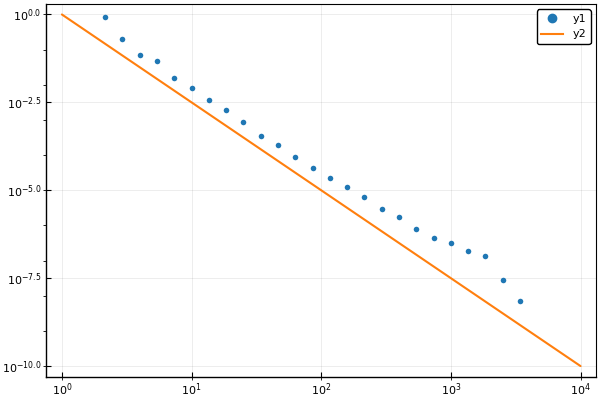

In [15]:
using StatsBase, Histograms

counts = reduce(vcat, out_sim)

h = Histograms.Histogram(float(counts), scale=:log)
plot(h, xscale=:log10, yscale=:log10, markershape=:auto, line=false)
x = range(1, 10000, length=10); y = x.^(-2.5)
plot!(x, y)

In [5]:
rmprocs(pros, waitfor=10)
procs()

1-element Array{Int64,1}:
 1

In [ ]:
using ApproxBayes, Distributions, Histograms, Distances

frac = 0.47
max_elem = 6670
in_mod = "mod2"
out_mod = "cc_distr"
dist_type = "bray"
epsilon = 0.2

function compare_sim_real(in_param, useless, real_distr)
    delta = in_param[1]/1000.0
    simdata = MainNetworkGrowth.Network_grow(delta, frac, max_elem, in_mod, out_mod, start_cnt=2)
    if dist_type == "bray"
        if length(simdata) >= 500
            return braycurtis(simdata[end-499:end], real_distr[end-499:end]), 1
        else
            throw(DomainError("too short unfortunately"))
        end
    elseif dist_type == "bin"
        h_sim = Histograms.Histogram(float(simdata), breaks=bins, scale=:log10)
        vec_norm = abs.(h_sim.counts .- real_distr)
        norm_dist = sum(filter(x -> x >= 0, log10.(vec_norm)))
        return norm_dist, 1
    end
end
    
setup = ABCRejection(compare_sim_real, #simulation function
  1, # number of parameters
  epsilon, # target ϵ
  Prior([Uniform(0.05, 0.9)]); # Prior for each of the parameters
  maxiterations = 5000, # Maximum number of iterations before the algorithm terminates
  nparticles = 5000,
  )

rejection = runabc(setup, real_lens, parallel=true) #  h_real.counts


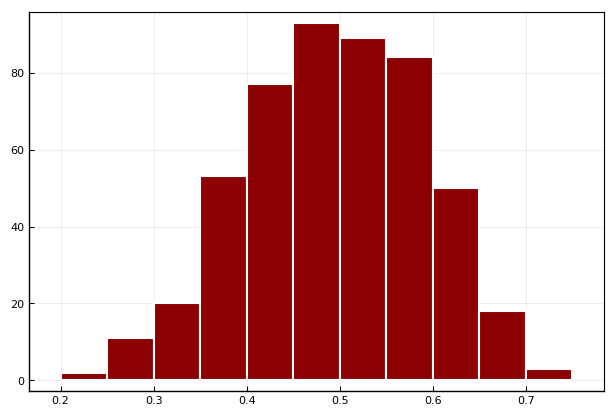

In [101]:
plot(rejection, title="")
#savefig("./pics/ABC_hist_delta.pdf")